# Energy studies

In [1]:
from array import array
from settings import gauss_exp
from settings import PROTON_THRESHOLD, ELECTRON_THRESHOLD

import math
import ROOT
ROOT.gStyle.SetPalette(ROOT.kBird)
ROOT.gROOT.ProcessLine("gErrorIgnoreLevel = 2002;")

Welcome to JupyROOT 6.14/04


2002

In [3]:
import electron_res as e
import importlib    # This command makes sure we load the last version of the module
importlib.reload(e) # No need to restart the kernel after modifications
p_preliminary = ROOT.TPaveText(0.08, 0.88, 0.7, 1, "NDC")
p_preliminary.SetFillStyle(0)
p_preliminary.SetBorderSize(0)
pot = 4.341e10
p_preliminary.AddText("MicroBooNE Simulation Preliminary")

In [4]:
max_energy = 2 + ELECTRON_THRESHOLD
n_bins = 10

In [5]:
h_electron_reco_true, h_true_electron, h_reco_electron = e.electron_calibration("data_files/mc_nue_sbnfit", 
                                                                                n_bins, max_energy, 1)

## Calibration studies
We measure the reconstructed electron energy in our sample using a $\nu_{e}$ CC0$\pi$-Np Monte Carlo. We sum the energy of all the reconstructed showers associated to the electron. The reconstructed energy distribution is fitted bin-by-bin with the GaussExp function (https://arxiv.org/abs/1603.08591).

The calibration points will have as $y$ value the MPV of the fitted GaussExp function and as $y$ error bar its FWHM. The $x$ value will be the mean of the $E^{e}$ distribution and the $x$ error bar will cover the entire bin.

### Electron calibration

 FCN=0.0351355 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=3.33351e-12    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  m            7.57392e-01   8.89728e-02   2.39197e-05   4.43796e-05
   2  q           -1.62024e-02   8.85408e-02   2.38024e-05   5.38692e-05


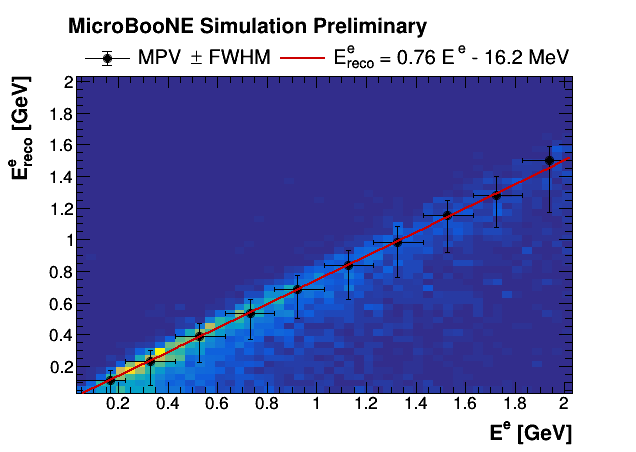

In [6]:
c_electron_reco_true = ROOT.TCanvas("c_electron_reco_true", "Calibration", 640,
                                    480)
g_electron_reco_true, x_values, x_errs_low, x_errs_high = e.calibration_graph(
    h_reco_electron, h_true_electron)

h_electron_reco_true.Draw("col")
h_electron_reco_true.SetMinimum(-0.001)
h_electron_reco_true.GetYaxis().SetTitleOffset(1.1)
h_electron_reco_true.GetXaxis().SetTitleOffset(1.1)

g_electron_reco_true.SetMarkerStyle(20)
g_electron_reco_true.Draw("p same")

f_line = ROOT.TF1("f_line", "[0]*x+[1]", 0, max_energy)
f_line.SetParNames("m", "q")
l_p_true_reco = ROOT.TLegend(0.12, 0.843, 0.900, 0.898)
l_p_true_reco.SetNColumns(2)
l_p_true_reco.AddEntry(g_electron_reco_true, "MPV #pm FWHM", "lep")
g_electron_reco_true.Fit(f_line, "")
m, q = f_line.GetParameter(0), f_line.GetParameter(1)
l_p_true_reco.AddEntry(
    f_line, "E_{reco}^{e} = %.2f E^{e} - %.1f MeV" % (m, -q * 1000), "l")
f_line.SetLineColor(ROOT.kRed + 1)
f_line.Draw("same")
p_preliminary.Draw()
l_p_true_reco.Draw()
c_electron_reco_true.SetLeftMargin(0.12)
c_electron_reco_true.SetBottomMargin(0.13)
c_electron_reco_true.SetTopMargin(0.17)

c_electron_reco_true.Draw()
c_electron_reco_true.SaveAs("plots/electron_calib.pdf")

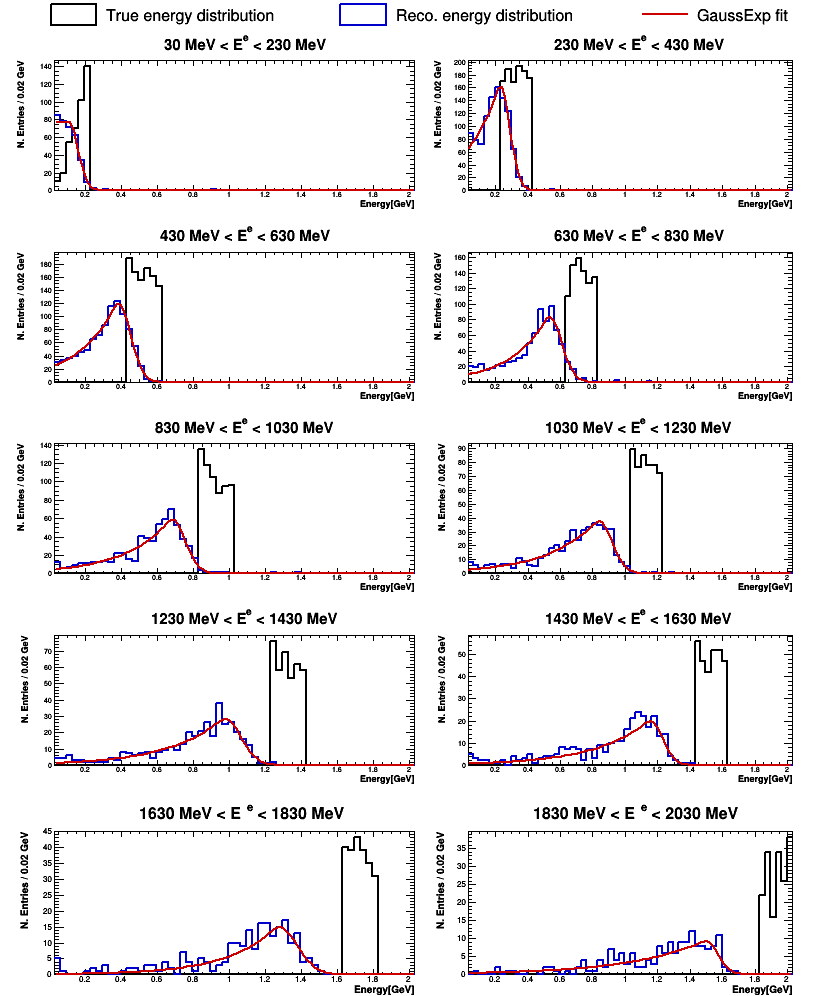

In [7]:
c_spectra = ROOT.TCanvas("c_spectra", "Spectra", 840, 1024)
c_spectra.cd()
c_spectra.Divide(2, 5, 0, 0)
leg = ROOT.TLegend(0.05, 0.97, 0.98, 1)
leg.SetNColumns(3)
leg.AddEntry(h_true_electron[0], "True energy distribution", "f")
leg.AddEntry(h_reco_electron[0], "Reco. energy distribution", "f")
leg.AddEntry(f_line, "GaussExp fit", "l")

obj = []
ROOT.gStyle.SetOptTitle(0)
for i in range(n_bins):
    c_spectra.cd(i + 1)
    ROOT.gPad.SetLeftMargin(0.13)
    ROOT.gPad.SetRightMargin(0.01)
    ROOT.gPad.SetTopMargin(0.22)
    ROOT.gPad.SetBottomMargin(0.1)
    pt = ROOT.TPaveText(0.2, 0.82, 0.97, 0.92, "NDC")
    pt.AddText(h_true_electron[i].GetTitle())
    pt.SetBorderSize(0)
    pt.SetFillStyle(0)
    h_true_electron[i].Draw()
    h_true_electron[i].SetLineColor(1)
    h_reco_electron[i].Draw("same")
    pt.Draw()
    obj.append(pt)
c_spectra.cd()
leg.Draw()
c_spectra.Draw()
c_spectra.SaveAs("plots/e_spectra.pdf")

## Energy resolution

The fractional energy difference is defined as:

$E_{\mathrm{frac}} = \frac{E^{e}_{\mathrm{corr}} - E^{e}}{E^{e}}$,

where $E^{e}_{\mathrm{corr}} = (E^{e}_{\mathrm{reco}} - B) / A$, with $A$ and $B$ being respectively the slope and the offset of the calibration plot.

The energy resolution $E_{\mathrm{res}}$ is defined as:

$E_{\mathrm{res}} = \frac{\sigma}{E^{e}}$,

where $\sigma$ is the width of the gaussian core of the GaussExp fit to the $E_{\mathrm{frac}}$ distribution.

In [8]:
h_res_electron = e.electron_resolution("data_files/mc_nue", m, q, n_bins, max_energy, 1)

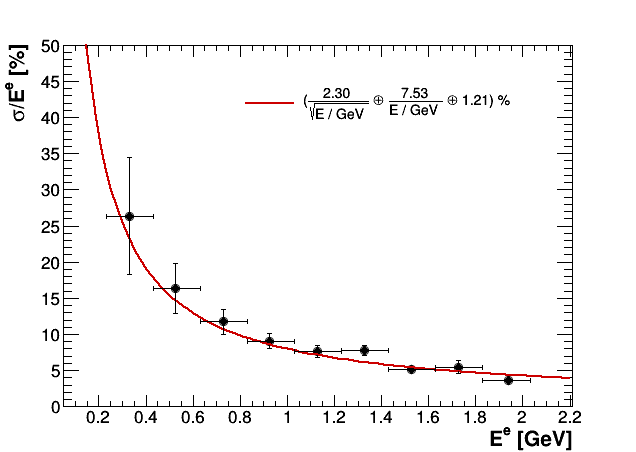

In [9]:
c_res_electron = ROOT.TCanvas("c_res_electron", "Electron resolution", 640,
                              480)
a_res = array("f", [])
a_res_err_h = array("f", [])
a_res_err_l = array("f", [])
fits = []
x_values_res = array("f", [])
x_errs_low_res = array("f", [])
x_errs_high_res = array("f", [])

for i in range(1, n_bins):
    f_gaussexp = ROOT.TF1("f_gausexp_%i" % i, gauss_exp, -1, 1, 4)
    f_gaussexp.SetParNames("n", "mu", "sigma", "k")
    f_gaussexp.SetParameter(2, 1)
    f_gaussexp.SetParameter(3, 0.4)
    f_gaussexp.SetParLimits(2, 0.07, 1.5)
    f_gaussexp.SetParLimits(3, 0.02, 1)
    if i == 1:
        h_res_electron[i].Fit(f_gaussexp, "RQ", "", -0.2, 0.3)
    elif 1 < i < 3:
        h_res_electron[i].Fit(f_gaussexp, "RQ", "", -0.2, 0.2)
    elif i == 3:
        h_res_electron[i].Fit(f_gaussexp, "RQ", "", -0.18, 0.18)
    elif (i > 3):
        h_res_electron[i].Fit(f_gaussexp, "RQ", "", -0.5, 0.4)

    fits.append(f_gaussexp)
    res = f_gaussexp.GetParameter(2) / x_values[i]
    a_res.append(res * 100)
    x_values_res.append(x_values[i])
    x_errs_low_res.append(x_errs_low[i])
    x_errs_high_res.append(x_errs_high[i])
    ratio_err = res * math.sqrt(
        (f_gaussexp.GetParError(2) / f_gaussexp.GetParameter(2))**2 +
        (0.2 / x_values[i])**2)
    a_res_err_h.append(ratio_err * 100 / 2)
    a_res_err_l.append(ratio_err * 100 / 2)

f_res = ROOT.TF1("f_res", "sqrt(([0]/sqrt(x))**2+([1]/x)**2+[2]**2)", 0, 2)
f_res.SetParNames("a", "b", "c")
f_res.SetParameter(0, 3)
f_res.SetParameter(1, 0.1)
f_res.SetParameter(2, 6)

f_res.SetParLimits(0, 2.3, 10)
f_res.SetParLimits(1, 0.01, 20)
f_res.SetParLimits(2, 1.21, 10)

g_e_res_e = ROOT.TGraphAsymmErrors(n_bins - 1, x_values_res, a_res,
                                   x_errs_low_res, x_errs_high_res,
                                   a_res_err_l, a_res_err_h)
g_e_res_e.SetTitle("")
g_e_res_e.Draw("ap")
g_e_res_e.Fit(f_res, "Q")
g_e_res_e.GetYaxis().SetTitleOffset(0.9)
g_e_res_e.GetYaxis().SetTitle("#sigma/E^{e} [%]")
g_e_res_e.GetXaxis().SetTitle("E^{e} [GeV]")
g_e_res_e.SetMarkerStyle(20)
g_e_res_e.GetHistogram().SetMaximum(50)
g_e_res_e.GetHistogram().SetMinimum(0)
l_res = ROOT.TLegend(0.37, 0.68, 0.80, 0.86)
l_res.AddEntry(
    f_res,
    "(#frac{%.2f}{#sqrt{E / GeV}} #oplus #frac{%.2f}{E / GeV} #oplus %.2f) %%"
    % (f_res.GetParameter(0), f_res.GetParameter(1), f_res.GetParameter(2)),
    "l")
l_res.Draw()
c_res_electron.Draw()
c_res_electron.SaveAs("plots/res_electron.pdf")

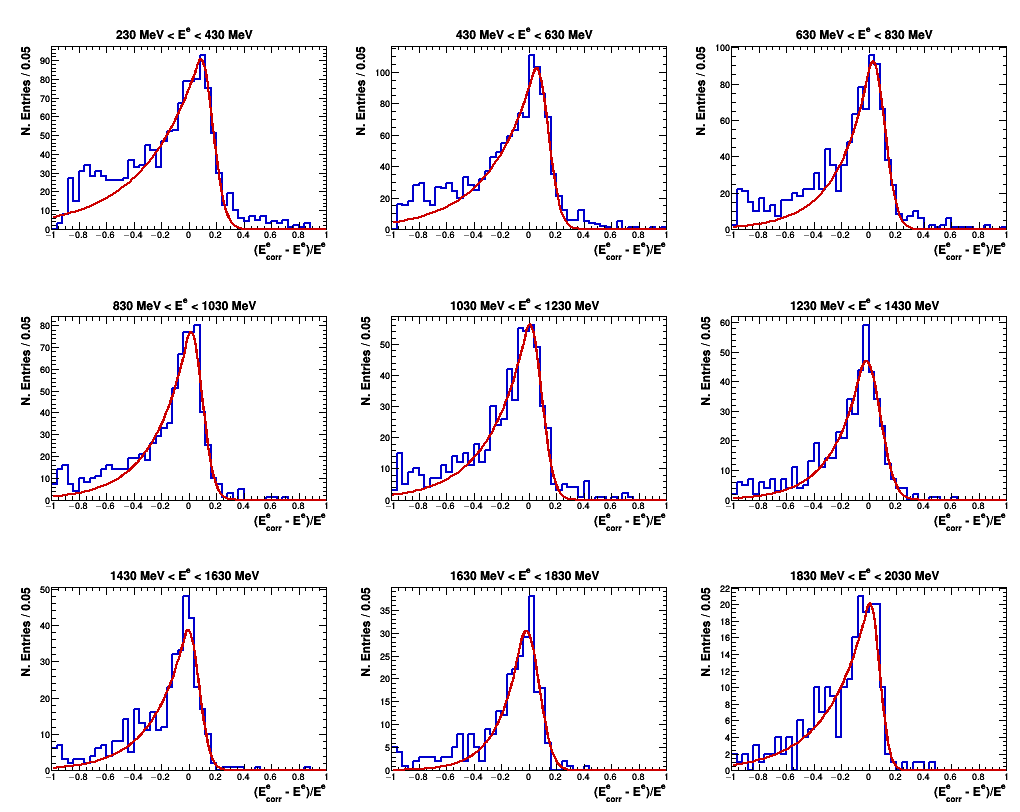

In [11]:
c_res = ROOT.TCanvas("c_res", "Resolution", 1024, 840)
c_res.cd()
ROOT.gPad.SetTopMargin(0.2)
c_res.Divide(3, 3)
ROOT.gStyle.SetOptTitle(0)
obj = []

for i in range(n_bins - 1):
    c_res.cd(i + 1)
    ROOT.gPad.SetLeftMargin(0.13)
    ROOT.gPad.SetRightMargin(0.01)
    ROOT.gPad.SetTopMargin(0.15)
    ROOT.gPad.SetBottomMargin(0.13)

    pt = ROOT.TPaveText(0.1, 0.87, 1, 0.93, "NDC")
    pt.AddText(h_res_electron[i + 1].GetTitle())
    pt.SetBorderSize(0)
    pt.SetFillStyle(0)
    h_res_electron[i + 1].Draw()
    h_res_electron[i + 1].GetXaxis().SetTitleOffset(1.1)

    fits[i].Draw("same")
    pt.Draw()
    obj.append(pt)

c_res.cd()
c_res.Draw()
c_res.SaveAs("plots/electron_res.pdf")

### Proton calibration

We divide the spectrum equally between the proton threshold, 40 MeV, and 440 MeV. Same procedure as the electron calibration. Here the energy is measured converting the track length into energy using the stopping power of proton in LAr.

In [34]:
proton_max_energy = 0.4 + PROTON_THRESHOLD
proton_n_bins = 8

In [35]:
h_proton_reco_true, h_true_proton, h_reco_proton = e.proton_calibration(
    "data_files/mc_nue", proton_n_bins, proton_max_energy, scale=1)

0 0.06717958035340998
1 0.10928717612730346
2 0.1639819070768331
3 0.20856383587015404
4 0.25666666635470875
5 0.3059035444716264
6 0.37666666505408214
7 0.4199999998902302


Info in ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Info in ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Info in ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 


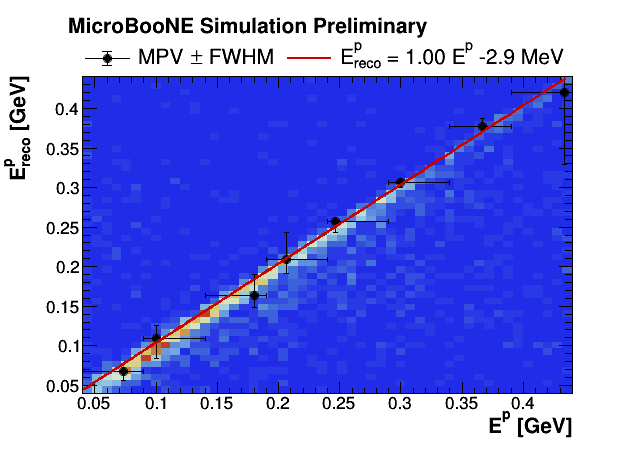

In [38]:
c_proton_reco_true = ROOT.TCanvas("c_proton_reco_true", "Calibration", 640,
                                  480)
g_proton_reco_true, x_values, x_errs_low, x_errs_high = e.calibration_graph_proton(
    h_reco_proton, h_true_proton)
h_proton_reco_true.Draw("col")
h_proton_reco_true.SetMinimum(-0.001)
g_proton_reco_true.SetMarkerStyle(20)
g_proton_reco_true.Draw("p same")
f_line = ROOT.TF1("f_line", "[0]*x+[1]", 0, 0.4)
f_line.SetParNames("m", "q")
f_line.SetParLimits(0, 0, 1)
l_p_true_reco = ROOT.TLegend(0.12, 0.843, 0.900, 0.898)
l_p_true_reco.SetNColumns(2)
l_p_true_reco.AddEntry(g_proton_reco_true, "MPV #pm FWHM", "lep")
g_proton_reco_true.Fit(f_line, "Q")
m, q = f_line.GetParameter(0), f_line.GetParameter(1)
l_p_true_reco.AddEntry(
    f_line, "E_{reco}^{p} = %.2f E^{p} %.1f MeV" % (m, -q * 1000), "l")
f_line.SetLineColor(ROOT.kRed + 1)
f_line.Draw("same")
l_p_true_reco.Draw()
p_preliminary.Draw()
c_proton_reco_true.SetLeftMargin(0.13)
c_proton_reco_true.SetBottomMargin(0.13)
c_proton_reco_true.SetTopMargin(0.17)
c_proton_reco_true.Draw()
c_proton_reco_true.SaveAs("plots/proton_calib.pdf")

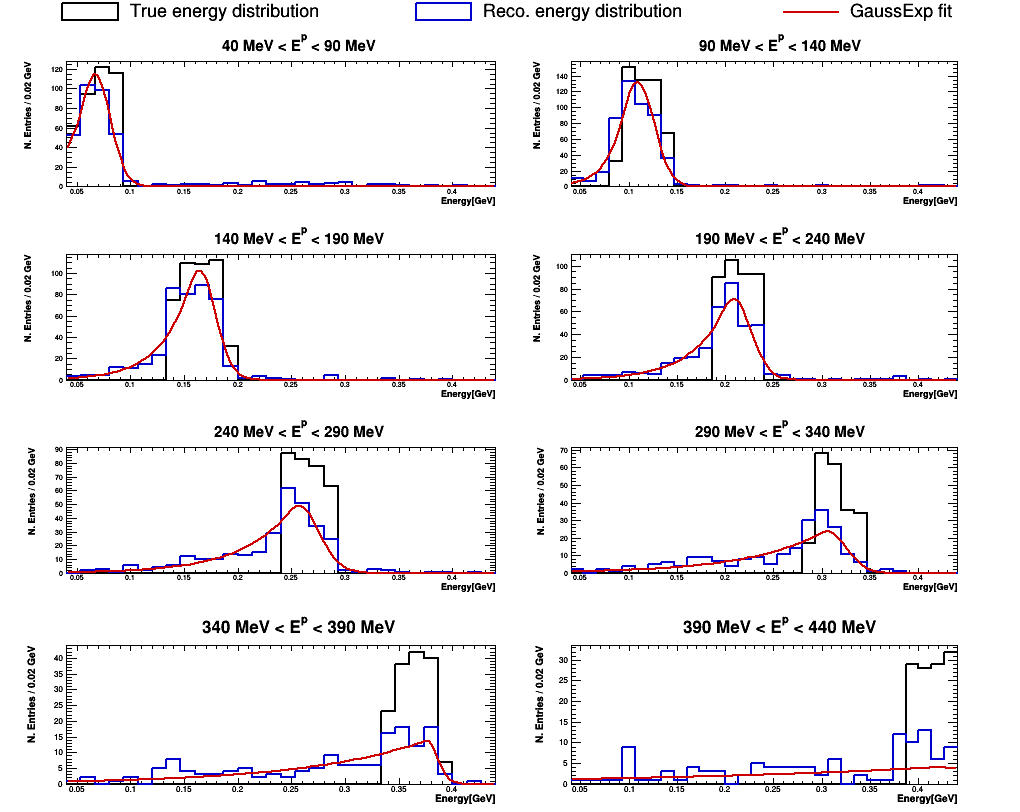

In [39]:
c_spectra_proton = ROOT.TCanvas("c_spectra_proton", "Spectra", 1024, 840)
c_spectra_proton.cd()
c_spectra_proton.Divide(2, 4, 0, 0)
obj = []
ROOT.gStyle.SetOptTitle(0)
for i in range(8):
    c_spectra_proton.cd(i + 1)
    ROOT.gPad.SetLeftMargin(0.13)
    ROOT.gPad.SetBottomMargin(0.13)
    ROOT.gPad.SetRightMargin(0.03)
    ROOT.gPad.SetTopMargin(0.22)
    pt = ROOT.TPaveText(0.2, 0.82, 0.97, 0.92, "NDC")
    pt.AddText(h_true_proton[i].GetTitle())
    pt.SetBorderSize(0)
    pt.SetFillStyle(0)
    h_true_proton[i].Draw()
    h_true_proton[i].SetLineColor(1)
    h_reco_proton[i].Draw("same")
    pt.Draw()
    obj.append(pt)
c_spectra_proton.cd()
leg.Draw()
c_spectra_proton.Draw()